# Classfication of news dataset

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import shap
import matplotlib.pyplot as plt

shap.initjs()

### Load the 20 Categories dataset

In [3]:
import json
corpus, y = [], []
with open('News_Category_Dataset_v2.json') as f:
    for line in f:
        obj = json.loads(line)
        corpus.append(obj['headline'] + '. ' + obj['short_description'])
        y.append(obj['category'])
y = np.array(y)
print(len(corpus))
print(y.shape)
print(corpus[-1])
print(y[-1])


200853
(200853,)
Dwight Howard Rips Teammates After Magic Loss To Hornets. The five-time all-star center tore into his teammates Friday night after Orlando committed 23 turnovers en route to losing
SPORTS


TRAVEL: 9887
STYLE & BEAUTY: 9649
WELLNESS: 8896
PARENTING: 8677
WORLD NEWS: 8420
ENTERTAINMENT: 8046
HEALTHY LIVING: 6694
POLITICS: 6585
QUEER VOICES: 6314
FOOD & DRINK: 6226
BUSINESS: 5937
COMEDY: 5175
SPORTS: 4884
BLACK VOICES: 4528
HOME & LIVING: 4195
PARENTS: 3955
ARTS: 3878
WEDDINGS: 3651
WOMEN: 3490
IMPACT: 3459
DIVORCE: 3426
CRIME: 3405
MEDIA: 2815
WEIRD NEWS: 2670
GREEN: 2622
RELIGION: 2556
STYLE: 2254
SCIENCE: 2178
EDUCATION: 2148
TASTE: 2096
TECH: 2082
MONEY: 1707
FIFTY: 1401
GOOD NEWS: 1398
ENVIRONMENT: 1323
LATINO VOICES: 1129


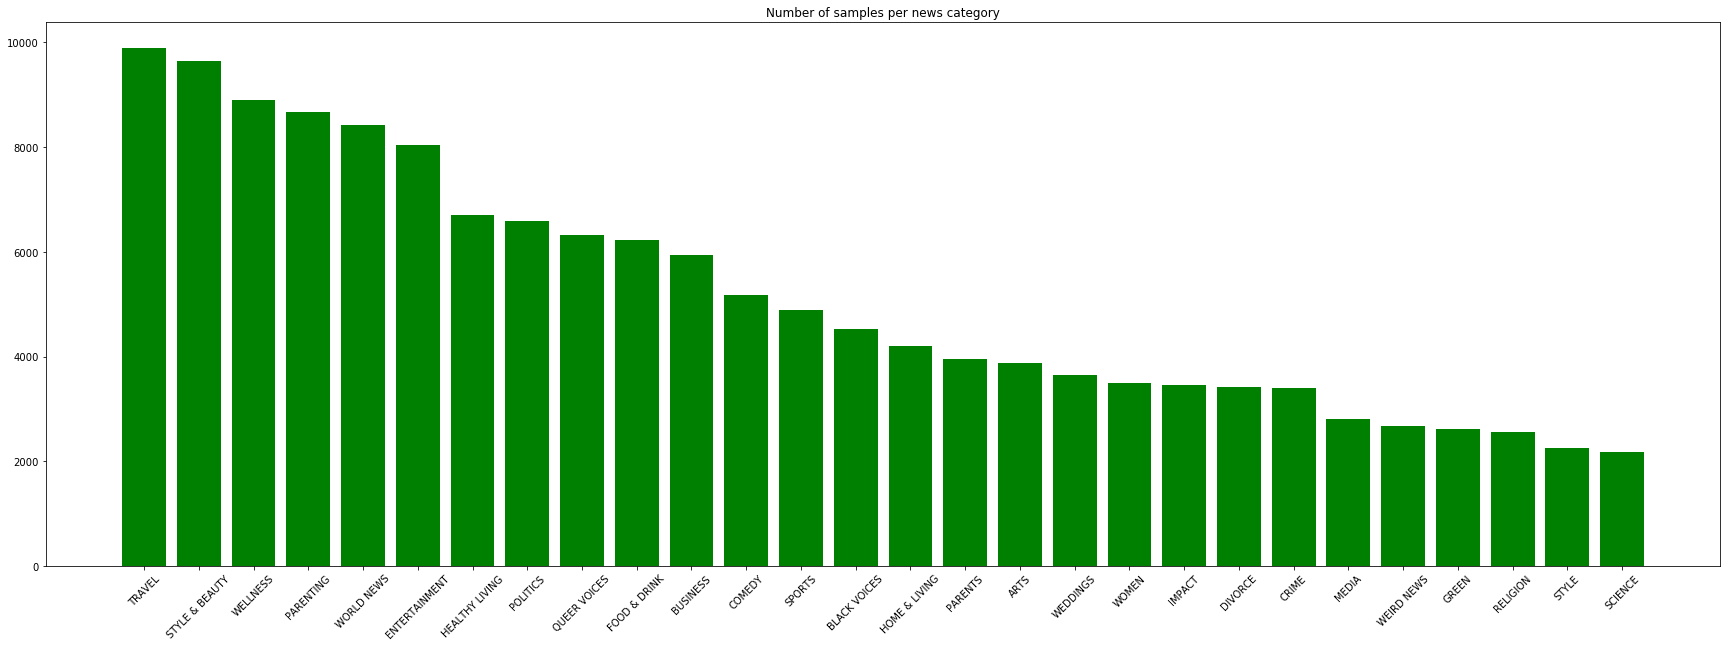

In [4]:
import collections
import random
count = collections.defaultdict(int)
article_length = collections.defaultdict(int)
corpus_new, y_new = [], [] 
max_length = 0
for i, label in enumerate(y):
    if label == 'ARTS & CULTURE' or label == 'CULTURE & ARTS':
        label = 'ARTS'
    if label == 'COLLEGE':
        label = 'EDUCATION'
    if label == 'WORLDPOST' or label == 'THE WORLDPOST':
        label = 'WORLD NEWS'
    if label == 'POLITICS' and random.random() < 0.8:
        continue
    if label == 'WELLNESS' and random.random() < 0.5:
        continue
    if label == 'ENTERTAINMENT' and random.random() < 0.5:
        continue
    count[label] += 1
    article_length[label] += len(corpus[i])
    corpus_new.append(corpus[i])
    y_new.append(y[i])
    max_length = max(max_length, len(corpus[i]))


    
keys, values, length = [], [], []
category_id, id_category = {}, {}
i = 0
for k, v in sorted(count.items(), key=lambda x: x[1], reverse=True):
    print(f'{k}: {v}')
    if v <= 2148:
        continue
    keys.append(k)
    values.append(v)
    length.append(article_length[k]/v)
    category_id[k] = i
    id_category[i] = k
    i += 1
x_pos = list(range(len(keys)))
X = [corpus_new[i] for i, label in enumerate(y_new) if label in category_id]
Y = [label for label in y_new if label in category_id]


fig, ax = plt.subplots(figsize=(30,10))
plt.bar(x_pos, values, color='green')
plt.title("Number of samples per news category")

plt.xticks(x_pos, keys, rotation=45)
plt.show()

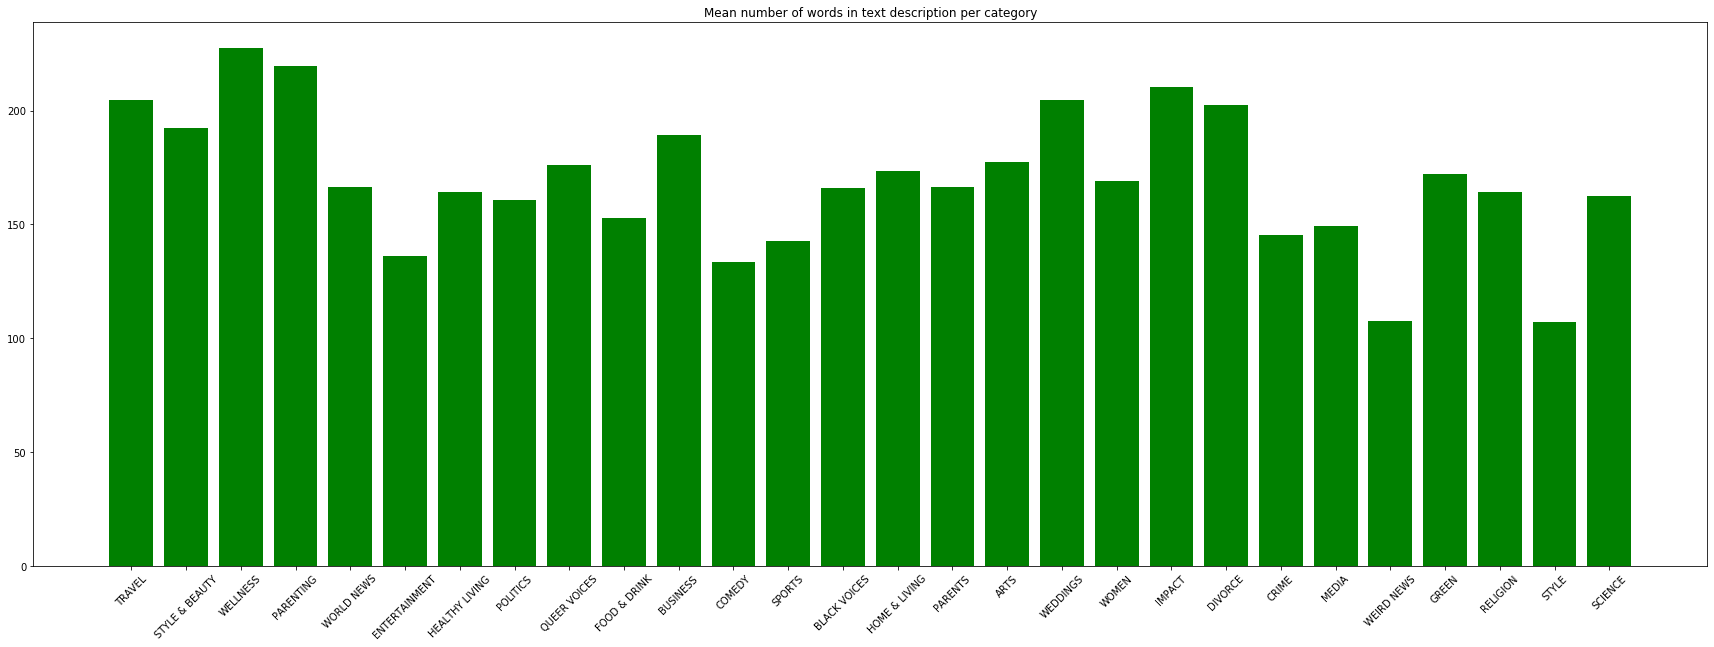

In [5]:
fig, ax = plt.subplots(figsize=(30,10))
plt.bar(x_pos, length, color='green')
plt.title("Mean number of words in text description per category")
plt.xticks(x_pos, keys, rotation=45)

plt.show()

## RNN

In [6]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
print(dummy_y.shape)
print(len(X))
print(X[0])
print(dummy_y[0])

(135860, 28)
135860
There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV. She left her husband. He killed their children. Just another day in America.
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [7]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

# pad sequences
max_length = max([len(s.split()) for s in X])
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
X_train, X_test, Y_train, Y_test = train_test_split(X, dummy_y, test_size=0.2, random_state=seed)

# define vocabulary size
vocab_size = len(tokenizer.word_index) + 1
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding='post')
X_test_pad  = pad_sequences(X_test_tokens,  maxlen=max_length, padding='post')

In [8]:
num_labels = len(Y_train[1])

print(X_train_pad.shape)
print(X_test_pad.shape)
print(X_train_pad[0])
print(Y_train[0])

print(num_labels)

(108688, 189)
(27172, 189)
[  342  1842     5  2553    11  1789   264    28  3067     7   135    38
     8    32    70   636     3  1147    19   101   330     9   342  1842
     5  2553    15   286     8    65   128    56  1051    35  7511   116
     2   177     9     1  1385  2550    17 20945     7  5111    20    75
   574    25    69 86031     1    31  7511     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding

EMBEDDING_DIM = 200
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length))
model.add(GRU(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_labels, activation='softmax'))

# try different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Summary of the built model...')
print(model.summary())

Summary of the built model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 189, 200)          19425200  
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               126336    
_________________________________________________________________
dense_2 (Dense)              (None, 28)                3612      
Total params: 19,555,148
Trainable params: 19,555,148
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train_pad, Y_train, batch_size=128, epochs=3, verbose=1, validation_split=0.2)

Train on 86950 samples, validate on 21738 samples
Epoch 1/3
22272/86950 [======>.......................] - ETA: 4:32 - loss: 3.2247 - acc: 0.0735

In [19]:
print(len(X_test_pad))
print(X_test_pad[0])
print(Y_test)

score, acc = model.evaluate(X_test_pad, Y_test, batch_size=3, verbose=1)
print('Test accuracy:', acc)

27172
[  123   692    12  6461     2   911    24   132    26   461     5   316
  1628    12   185   245    33 16796  9692     9   167   104   743  2773
    26   461    13    44   132    12  8387     2  8430     6   505    12
   121   167   106     3   168   524    41    56   743    17  7055   658
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0   

In [10]:
from sklearn.linear_model import LogisticRegression
multi_class = 'ovr'
clf = LogisticRegression(solver='sag', max_iter=100, random_state=42, multi_class=multi_class).fit(X_train, y_train)
#clf = LogisticRegression(solver='liblinear', penalty = 'l2', C = 1.0, max_iter=100, random_state=42, multi_class=multi_class).fit(X_train, y_train)

# print the training scores
print("training score : %.3f (%s)" % (clf.score(X_train, y_train), multi_class))
print("testing score : %.3f (%s)" % (clf.score(X_test, y_test), multi_class))

# CounterVectorizer()
# training score : 0.841 (ovr)
# testing score : 0.612 (ovr)

# CountVectorizer(stop_words='english', min_df=10)
# training score : 0.802 (ovr)
# testing score : 0.592 (ovr)

/home/brentweiliu/anaconda3/envs/my_notebook/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


training score : 0.854 (ovr)
testing score : 0.573 (ovr)


In [11]:
import numpy as np
import seaborn as sn
from matplotlib.colors import LogNorm
y_true = y_test
y_pred = clf.predict(X_test)
labels={label:idx for idx, label in enumerate(list(set(y_test)))}
print(labels)
n = len(labels)
cm = np.zeros((n, n))

for t, p in zip(y_true, y_pred):
    i, j = labels[t], labels[p]
    cm[i, j] += 1
print(cm) 
print(cm.max())

{'BLACK VOICES': 0, 'SPORTS': 1, 'BUSINESS': 2, 'CULTURE & ARTS': 3, 'QUEER VOICES': 4, 'HEALTHY LIVING': 5, 'PARENTS': 6, 'THE WORLDPOST': 7, 'HOME & LIVING': 8, 'SCIENCE': 9, 'ARTS & CULTURE': 10, 'WEIRD NEWS': 11, 'WELLNESS': 12, 'WORLDPOST': 13, 'WOMEN': 14, 'STYLE & BEAUTY': 15, 'ARTS': 16, 'LATINO VOICES': 17, 'DIVORCE': 18, 'FIFTY': 19, 'TASTE': 20, 'RELIGION': 21, 'STYLE': 22, 'GOOD NEWS': 23, 'COMEDY': 24, 'MEDIA': 25, 'COLLEGE': 26, 'TRAVEL': 27, 'PARENTING': 28, 'EDUCATION': 29, 'POLITICS': 30, 'ENVIRONMENT': 31, 'GREEN': 32, 'MONEY': 33, 'IMPACT': 34, 'FOOD & DRINK': 35, 'TECH': 36, 'CRIME': 37, 'WEDDINGS': 38, 'ENTERTAINMENT': 39, 'WORLD NEWS': 40}
[[4.240e+02 2.800e+01 1.100e+01 ... 5.000e+00 9.200e+01 2.000e+00]
 [1.800e+01 6.830e+02 6.000e+00 ... 2.000e+00 2.700e+01 1.000e+00]
 [1.100e+01 1.000e+01 6.380e+02 ... 3.000e+00 1.800e+01 6.000e+00]
 ...
 [3.000e+00 2.000e+00 1.000e+00 ... 5.450e+02 1.200e+01 0.000e+00]
 [5.600e+01 2.000e+01 6.000e+00 ... 1.000e+01 1.089e+03 0

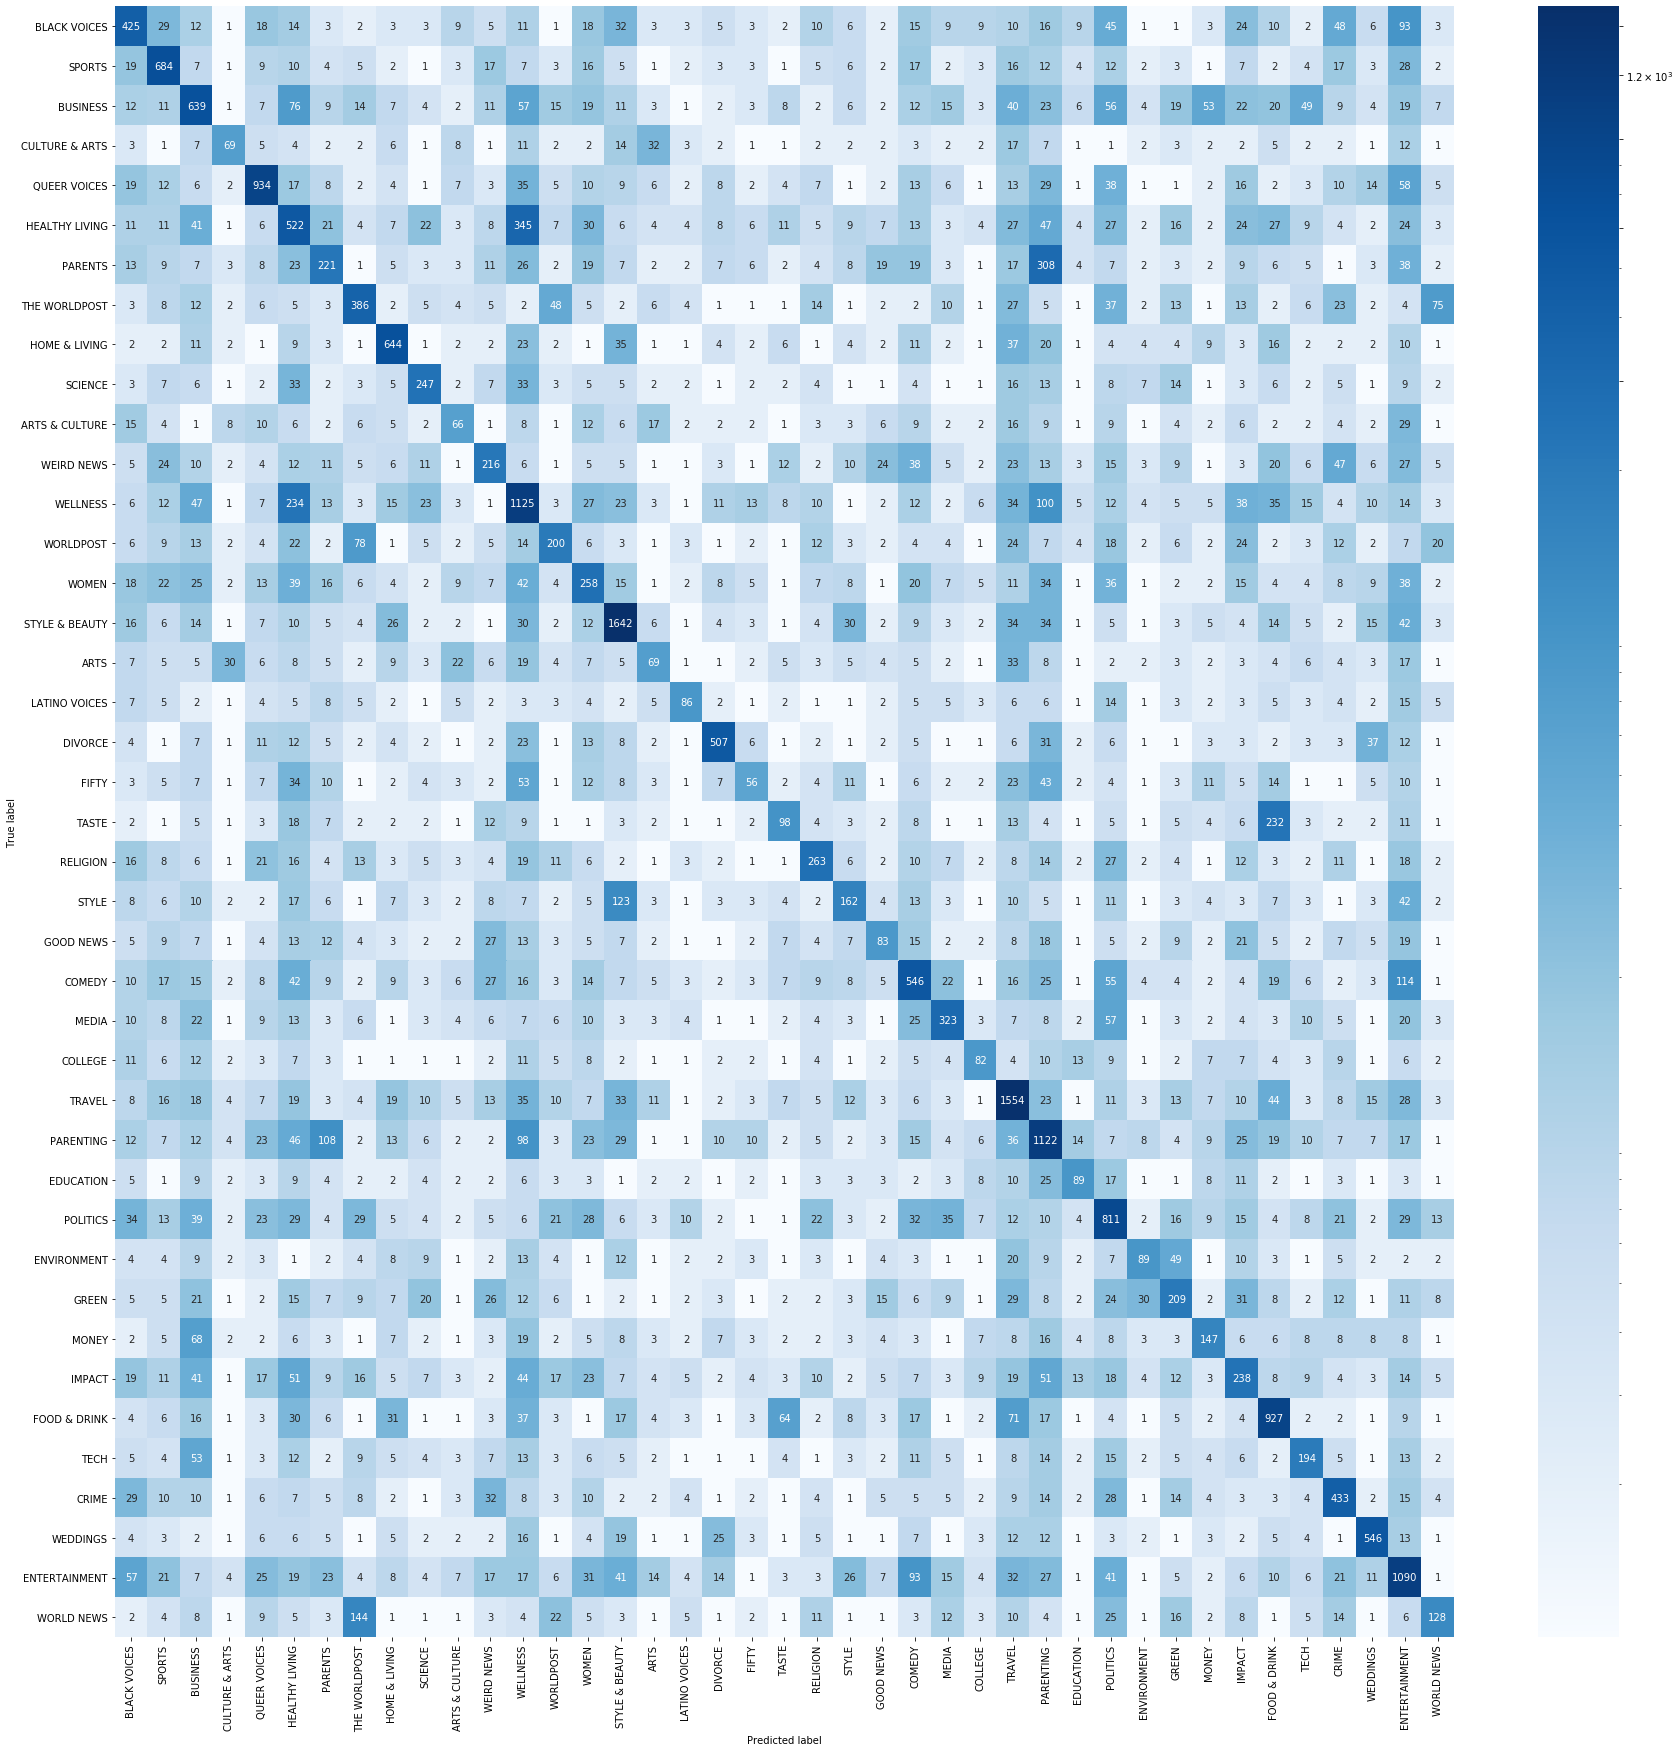

In [12]:
fig, ax = plt.subplots(figsize=(30,30))
cm += 1
heatmap = sn.heatmap(cm,  cmap="Blues", annot=True, fmt='g', norm=LogNorm(vmin=cm.min(), vmax=cm.max()),
                     xticklabels=labels.keys(), yticklabels=labels.keys(), ax=ax)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [13]:
from sklearn.metrics import multilabel_confusion_matrix
y_pred = clf.predict(X_test)
labels=list(set(y_test))
cm = multilabel_confusion_matrix(y_test, y_pred, labels=labels)
for i, label in enumerate(labels):
    print(f'{i}, {label}, \n{cm[i]}')


0, BLACK VOICES, 
[[30321   384]
 [  459   424]]
1, SPORTS, 
[[30370   308]
 [  227   683]]
2, BUSINESS, 
[[29756   590]
 [  604   638]]
3, CULTURE & ARTS, 
[[31321    60]
 [  139    68]]
4, QUEER VOICES, 
[[30033   277]
 [  345   933]]
5, HEALTHY LIVING, 
[[29378   914]
 [  775   521]]
6, PARENTS, 
[[30468   320]
 [  580   220]]
7, THE WORLDPOST, 
[[30508   369]
 [  326   385]]
8, HOME & LIVING, 
[[30519   219]
 [  207   643]]
9, SCIENCE, 
[[31006   150]
 [  186   246]]
10, ARTS & CULTURE, 
[[31235   104]
 [  184    65]]
11, WEIRD NEWS, 
[[30763   262]
 [  348   215]]
12, WELLNESS, 
[[28615  1118]
 [  731  1124]]
13, WORLDPOST, 
[[30887   203]
 [  299   199]]
14, WOMEN, 
[[30535   380]
 [  416   257]]
15, STYLE & BEAUTY, 
[[29123   493]
 [  331  1641]]
16, ARTS, 
[[31173   126]
 [  221    68]]
17, LATINO VOICES, 
[[31333    54]
 [  116    85]]
18, DIVORCE, 
[[30768   124]
 [  190   506]]
19, FIFTY, 
[[31180    77]
 [  276    55]]
20, TASTE, 
[[30999   147]
 [  345    97]]
21, RELIGION